
<img align="left" src = https://noirlab.edu/public/media/archives/logos/svg/logo250.svg width=250 style="background-color:white; padding:10px" alt="Rubin Observatory logo, a graphical representation of turning stars into data.">
<br>
<b> Science Preparation Seminars: Active Galactic Nuclei </b> <br>
Contact author(s): Gloria Fonseca Alvarez, Greg Madejski <br>
Last verified to run: 2025-04-16 <br>
LSST Science Pipelines version: Weekly 2025_09 <br>
Container Size: medium <br>


**Description:** Use catalog data to identify variable objects and plot their lightcurves.

**Skills:** Access DP0.2 catalogs through TAP. Plot lightcurves and color-color diagrams. Analyze time series data.

**LSST Data Products:** DP0.2 catalogs: `Object`, `ForcedSource`, `DiaObject`, `ForcedSourceOnDiaObject`

**Packages:** `lsst.rsp`, `astropy`, `scipy`

**Credit:**  This notebook contains material drawn from DP0.2 tutorial notebooks 07a_DiaObject_Samples and 07b_Variable_Star_Lightcurves originally authored by Melissa Graham, Ryan Lau, Jeff Carlin, and Bob Abel. It also includes material from example notebooks authored by Andjelka Kovacevic, Isidora Jankov & Viktor Radovic.

**Get Support:**
Everyone is encouraged to ask questions or raise issues in the 
<a href="https://community.lsst.org/c/support">Support Category</a> 
of the Rubin Community Forum.
Rubin staff will respond to all questions posted there.

## 1. Introduction

This notebook demonstrates use of the Table Access Protocol (TAP) service to explore time-domain and data products for variable point-like objects in the DP0.2 catalogs. The DP0.2 dataset is based on the the simulated, Legacy Survey of Space and Time (LSST)-like images generated by the Dark Energy Science Collaboration (DESC) for their Data Challenge 2 (DC2; arXiv:2010.05926).

> **Notice:** The DP0.2 simulated data does not contain Active Galactic Nuclei, so the objects in this notebook are likely variable stars.

Section 2 demonstrates how to access lightcurve data for a known RR Lyrae star, based on its ra and dec, and some initial analysis. 

Section 3 demonstrates how to access lightcurve summary statistics and explores identifying potential AGN variability. 

Section 4 demonstrates how to access the object catalog photometry and explores using color-color diagrams and lightcurves to identify potential AGN.  

### 1.1 Import Packages

Import general science and astronomy packages, and specific packages from the [LSST Science Pipelines](https://pipelines.lsst.io/).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.units as u

from astropy.table import unique
from astropy.table import Table
from astropy.timeseries import LombScargle

from scipy import signal
from scipy.stats import binned_statistic
from astroML.time_series import generate_damped_RW as drw

from lsst.rsp import get_tap_service

### 1.2 Define parameters and functions

Set up defaults for plotting. 

In [2]:
%matplotlib inline
plt.style.use('tableau-colorblind10')
params = {'axes.labelsize': 14,
          'font.size': 14,
          'legend.fontsize': 14,
          'xtick.major.width': 3,
          'xtick.minor.width': 2,
          'xtick.major.size': 12,
          'xtick.minor.size': 6,
          'xtick.direction': 'in',
          'xtick.top': True,
          "xtick.minor.visible": True,
          'lines.linewidth': 3,
          'axes.linewidth': 3,
          'axes.labelweight': 3,
          'axes.titleweight': 3,
          'ytick.major.width': 3,
          'ytick.minor.width': 2,
          'ytick.major.size': 12,
          'ytick.minor.size': 6,
          'ytick.direction': 'in',
          'ytick.right': True,
          "ytick.minor.visible": True,
          'figure.figsize': [10, 8],
          'figure.facecolor': 'White'}
plt.rcParams.update(params)

Set up colors and plot symbols corresponding to the _ugrizy_ bands.

In [3]:
plot_filter_labels = ['u', 'g', 'r', 'i', 'z', 'y']
plot_filter_colors = {'u': '#0c71ff', 'g': '#49be61', 'r': '#c61c00',
                      'i': '#ffc200', 'z': '#f341a2', 'y': '#5d0000'}
plot_filter_symbols = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}

Define a function to create a LombScargle periodogram using astropy.

In [4]:
def calc_periodogram(time, mags, min_period, max_period):

    min_freq_search = 1.0 / (max_period * u.day)
    max_freq_search = 1.0 / (min_period * u.day)

    frequency, power = LombScargle(LC_mjd, LC_mag).autopower(minimum_frequency=min_freq_search, maximum_frequency=max_freq_search)

    return frequency, power

Define a function to calculate a structure function (SF). Structure Function definition as presented in Kovačević et al. 2021 and shared in [AGN_cadences](https://github.com/LSST-sersag/agn_cadences/tree/main). 

In [5]:
def calc_SF(t,y,z=0):
    
    dtr = []
    dyr = []
    obs = np.asarray(y.shape)[0]
    for i in range(obs-1):
        dtr.append(t[i+1:obs] - t[i])
        dyr.append((y[i+1:obs] - y[i])*(y[i+1:obs] - y[i]))

    dtr = np.concatenate(dtr, axis=0)
    dyr = np.concatenate(dyr, axis=0)
    
    s, edges, _ = binned_statistic(dtr/(1+z), dyr, statistic='mean', bins=np.logspace(0,4,100))
    
    return s, edges

### 1.3 Initialize the TAP service

The TAP service is used to retrive all of the data in this notebook.

In [6]:
service = get_tap_service("tap")

## 2. Create lightcurves using forced photometry from the ForcedSource table

### 2.1 Plot multi-band lightcurves

This section will demonstrate how to create lightcurves in the _ugrizy_ bands for an object starting with a known ra and dec. 

The `ForcedSource` table provides forced photometry measurements in single visit images at the locations of objects in the `Object` table. Each measurement in the `ForcedSource` table can be identified by `objectId`. The time information is included in the `CcdVisit` table.

#### 2.1.1 Define coordinates of known object of interest

There is a known RR Lyrae star in the DP0.2 data at the position (RA, Dec) = (62.1479031, -35.799138) degrees.

In [7]:
ra  =  62.1479031
dec =  -35.799138

#### 2.1.2 Query the Object Table to find the objectId that matches the coordinates

Create a spatial query for a 0.001 degree radius around the defined ra and dec. Include a constraint for "detect_isPrimary = 1". The <a href="https://pipelines.lsst.io/getting-started/multiband-analysis.html#filtering-for-unique-deblended-sources-with-the-detect-isprimary-flag">detect_isPrimary flag</a> is a composite flag that, if TRUE (or set to 1), ensures a unique, deblended source.

In [8]:
query = "SELECT TOP 100 "\
        "objectId, coord_ra, coord_dec, "\
        "detect_isPrimary "\
        "FROM dp02_dc2_catalogs.Object "\
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec), "\
        "CIRCLE('ICRS'," + str(ra) + ", "\
        + str(dec) + ", 0.001)) = 1 "\
        "AND detect_isPrimary = 1"

Run the query and retrieve the results.

In [9]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [10]:
object_table = job.fetch_result().to_table()

Show the results of the query.

In [11]:
object_table

objectId,coord_ra,coord_dec,detect_isPrimary
,deg,deg,
int64,float64,float64,bool
1651589610221899038,62.1479018,-35.7991382,True


Extract the objectId. 

In [12]:
object_id = object_table['objectId'][0]
object_id

np.int64(1651589610221899038)

#### 2.1.3 Query the ForcedSource and CcdVisit table for lightcurve information

Create a query for all sources in the ForcedSource table matching the specified objectId. Join the Ccd visit table to get visit information.  

Use the `scisql_nanojanskyToAbMag` and `scisql_nanojanskyToAbMag` functions to convert fluxes to magnitudes within the query.

In [13]:
query = "SELECT src.objectId, src.forcedSourceId, src.coord_ra, src.coord_dec, src.band, "\
        "src.psfFlux, src.ccdVisitId, "\
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "visinfo.ccdVisitId, visinfo.expMidptMJD, visinfo.band "\
        "FROM dp02_dc2_catalogs.ForcedSource as src "\
        "JOIN dp02_dc2_catalogs.CcdVisit as visinfo "\
        "ON visinfo.ccdVisitId = src.ccdVisitId "\
        "WHERE src.objectId = "+str(object_id)+" "
#print(query)

Run the query and retrieve the results.

In [14]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [15]:
forced_source_table = job.fetch_result().to_table()

Show the results of the query. 

In [16]:
#forced_source_table

#### 2.1.4 Plot the lightcurve for multiple bands

Create a dictionary named 'pick' to facilitate filtering measurements for specific bands.

In [17]:
pick = {}
for band in plot_filter_labels:
    pick[band] = (forced_source_table['band'] == band)

Plot the lightcurve for each band.

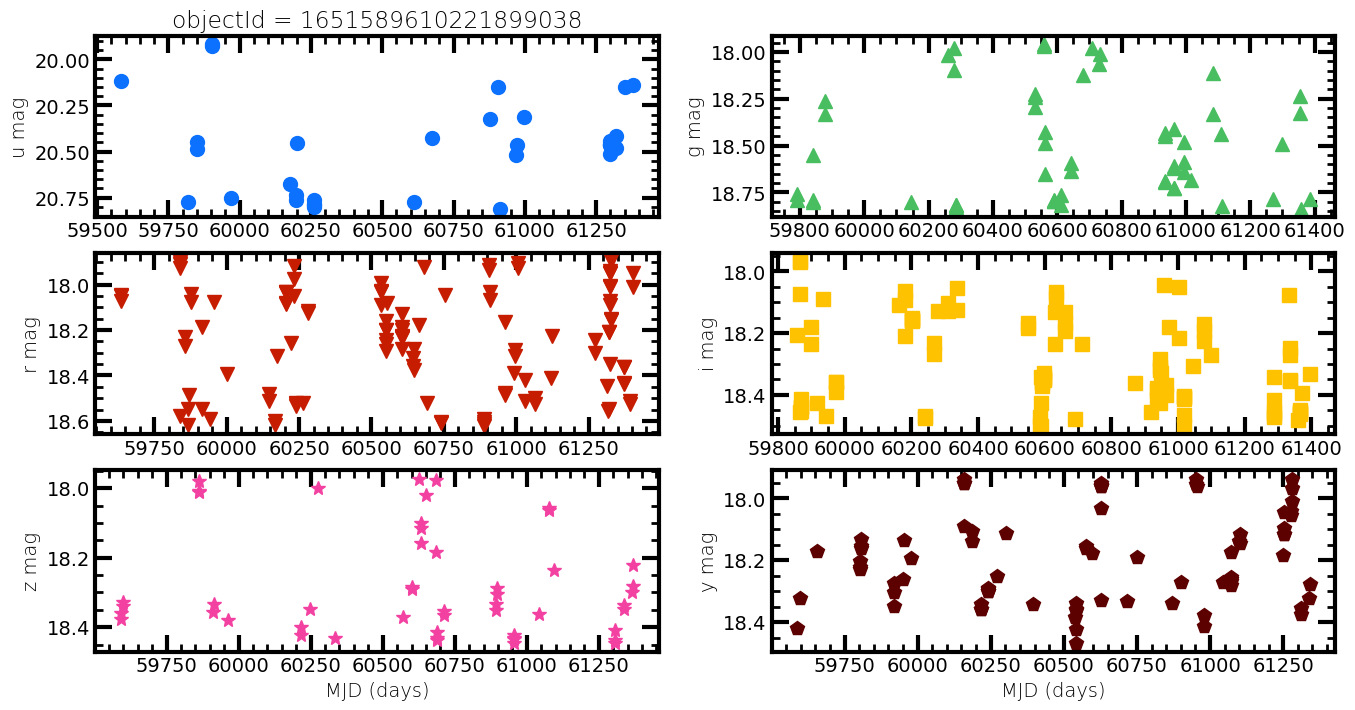

In [18]:
fig, ax = plt.subplots(3, 2, figsize=(16, 8), sharey=False, sharex=False)

ax = ax.flatten()

for i, band in enumerate(plot_filter_labels):
    
    ax[i].plot(forced_source_table[pick[band]]['expMidptMJD'], forced_source_table[pick[band]]['psfMag'],
         plot_filter_symbols[band], ms=10, color=plot_filter_colors[band])
    ax[i].set_ylabel("{0} mag".format(band))
    ax[i].invert_yaxis()

ax[0].set_title("objectId = {0}".format(object_id))
ax[4].set_xlabel('MJD (days)')
ax[5].set_xlabel('MJD (days)')
plt.tick_params(axis='both', direction="in")
plt.show()

### 2.2 Investigate variability timescales

Store the i-band lightcurve and sort by mjd. 

In [19]:
LC_mjd = forced_source_table[forced_source_table['band'] == 'i']['expMidptMJD']
LC_mag = forced_source_table[forced_source_table['band'] == 'i']['psfMag']

sort_index = np.argsort(LC_mjd)
LC_mjd = LC_mjd[sort_index]
LC_mag = LC_mag[sort_index]

#### 2.2.1 Extract potential periods of variability from a Lomb-Scargle periodogram

Call the function defined at the top of the notebook to look for periods between 0.05 and 1.05 days. RR Lyrae stars have periods ~0.2-0.9 days.

In [20]:
frequency, power = calc_periodogram(LC_mjd, LC_mag, 0.05, 1.05)

Extract the frequency for the peak in the periodogram. Calculate the most likely period of variability. 

In [21]:
peak_bin = np.argmax(power)
peak_freq = frequency[peak_bin].value
best_period = 1/peak_freq

Plot the periodogram using frequency and period. 

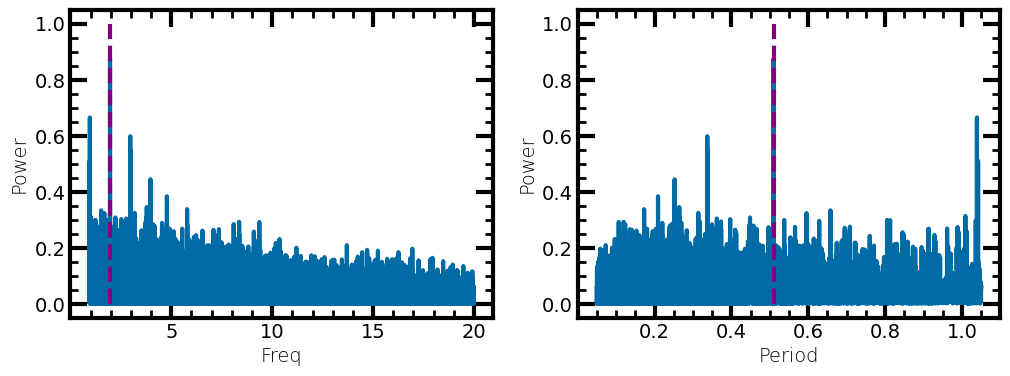

In [22]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4))

ax[0].plot(frequency, power)
ax[0].vlines(peak_freq, 0, 1, linestyle='--', color='purple')
ax[0].set_xlabel('Freq')
ax[0].set_ylabel('Power')

ax[1].plot(1/frequency, power)
ax[1].vlines(1/peak_freq, 0, 1, linestyle='--', color='purple')
ax[1].set_xlabel('Period')
ax[1].set_ylabel('Power')

plt.show()

#### 2.2.2 Calculate the structure function for the star

Calculate the structure function for the variability of the star. The structure function is a commonly used tool to study AGN variability. 

In [23]:
SF = calc_SF(LC_mjd, LC_mag)

Plot the structure function. 

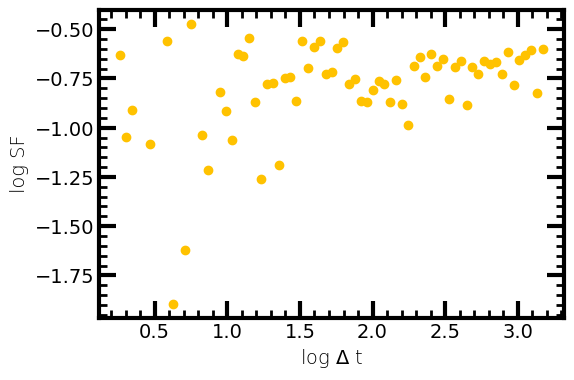

In [24]:
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(np.log10(SF[1][:-1] + np.diff(SF[1])/2), np.log10(np.sqrt(SF[0])), 'o', color=plot_filter_colors['i'])
ax.set_ylabel('log SF')
ax.set_xlabel(r'log $\Delta$ t')
plt.show()

#### 2.2.3 Plot a structure function for AGN-like variability

Retrieve a simulated AGN lightcurve of similar magnitude to the variable star. The lightcurve is produced by the `generate_damped_RW` function from the `astroML` module, spanning the full range of the RR Lyrae lightcurve with mean magnitude in the i-band = 18.2, SF$\inf$ = 0.2, and $\tau$ = 300. 

In [25]:
full_AGN_lc = Table.read("data/full_AGN_lc.csv", format="csv")
full_times = full_AGN_lc['time']
full_mags = full_AGN_lc['magnitude']

To account for the cadence of the DP0.2 simulation, we keep only the lightcurve points corresponding to dates when the star was observed.

> **Notice:** The simulated data in the DP0.2 used an observing cadence that differs from the most recent survey strategy plans. Additionally, it does not contain any Deep Drilling Fields (DDF). 

In [26]:
obs_AGN_lc = Table.read("data/observed_AGN_lc.csv", format="csv")
obs_times = obs_AGN_lc['time']
obs_mags = obs_AGN_lc['magnitude']

Calculate the structure function for the full AGN lightcurve, and the lightcurve matching the times when the star was observed.

In [27]:
SF_cadence = calc_SF(obs_times, obs_mags)
SF_full    = calc_SF(full_times, full_mags)

Plot the lightcurves and the structure function.

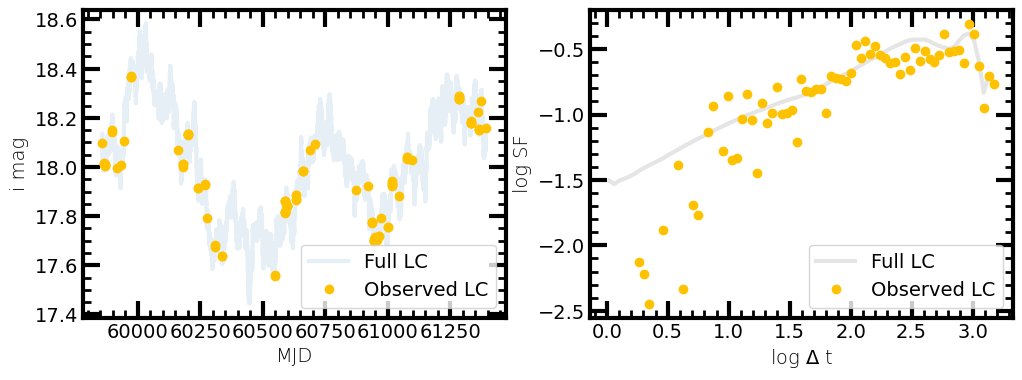

In [28]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].plot(full_times, full_mags, '-', alpha = 0.1, label='Full LC')
ax[0].plot(obs_times, obs_mags, 'o', color=plot_filter_colors['i'], label = 'Observed LC')
ax[0].set_xlabel('MJD')
ax[0].set_ylabel('i mag')
ax[0].legend(loc='lower right')

ax[1].plot(np.log10(SF_full[1][:-1]+np.diff(SF_full[1])/2), np.log10(np.sqrt(SF_full[0])), '-', color='black', alpha = 0.1, label='Full LC')
ax[1].plot(np.log10(SF_cadence[1][:-1]+np.diff(SF_cadence[1])/2), np.log10(np.sqrt(SF_cadence[0])), 'o', color=plot_filter_colors['i'], label='Observed LC')
ax[1].set_ylabel('log SF')
ax[1].set_xlabel(r'log $\Delta$ t')
ax[1].legend(loc='lower right')

plt.show()

## 3. Identify objects by variability parameters from the DiaObject Table

AGN exhibit longterm, stochastic variability in all bands. In photometric surveys, AGN can be identified by their variability signatures. The `DiaObject` table provides lightcurve summary statistics that can be used to identify potential objects of interest.

### 3.1 Explore lightcurve summary statistics

The `DiaObject` table includes the following: 

**nDiaSources:** The number of difference-image detections in any filter (i.e., number of DiaSources associated with a given DiaObject).
 
The following statistics are all based on _difference-image point source (PS) flux values_ for each filter [f].<br>
**[f]PSFluxMin:** The faintest flux. <br>
**[f]PSFluxMax:** The brightest flux. <br>
**[f]PSFluxMean:** The average flux. <br>
**[f]PSFluxSigma:** The standard deviation of the fluxes. <br>
**[f]PSFluxMAD:** The mean absolute deviation of the fluxes (i.e., the average distance from the mean). <br>
**[f]PSFluxChi2:** The Chi2 statistic for the scatter of the fluxes around the mean. <br>
**[f]PSFluxNdata:** The number of data points used to compute [f]PSFluxChi2. <br>
**[f]PSFluxSkew:** A measure of asymmentry in the distribution of fluxes about the mean (where 0 means symmetric). <br>
**[f]PSFluxStetsonJ:** A variability index developed for Cepheids (defined in <a href="https://ui.adsabs.harvard.edu/abs/1996PASP..108..851S/abstract">Stetson 1996</a>). <br>
**[f]PSFluxPercentile05, 25, 50, 75, 95:** Derived from the cumulative distribution of flux values. <br>

The following statistics are all based on the _direct-image total (TOT) flux values_ for each filter [f]. <br>
**[f]TOTFluxMean:** The average flux.  <br>
**[f]TOTFluxSigma:** The standard deviation of the fluxes.  <br>

> **Notice:** The DP0.2 DiaObject table is missing some variability characterization parameters (<a href="https://dmtn-118.lsst.io">DMTN-118</a>) and host association parameters (<a href="https://dmtn-151.lsst.io">DMTN-151</a>) which will exist for future data releases.

#### 3.1.1 Query the DiaObject table for well sampled objects near the center of the simulated data

Define the coordinates for the center of the DC2 simulation.

In [29]:
center_ra = 62
center_dec = -37

Create a query for DiaObjects within 5 degrees of the central coordinates. Extract the number of DiaSources (PSFluxNdata) for each band. 

In [30]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, diao.nDiaSources, "\
        "diao.gPSFluxNdata, diao.rPSFluxNdata, diao.iPSFluxNdata, "\
        "diao.uPSFluxNdata, diao.zPSFluxNdata, diao.yPSFluxNdata "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "WHERE diao.nDiaSources > 100 "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(center_ra)+", "+str(center_dec)+", 5)) = 1 "
#print(query)

Run the query and retrieve the results.

In [31]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [32]:
dia_object_table = job.fetch_result().to_table()

#### 3.1.2 Plot the distribution of number of DiaSources per DiaObject per band

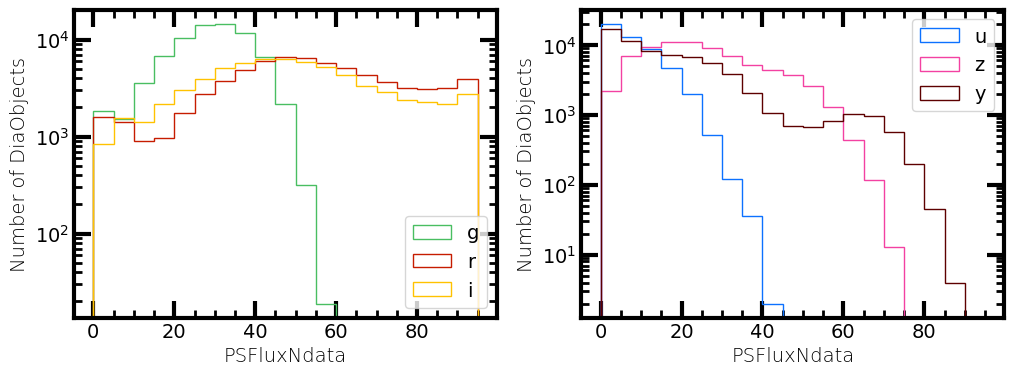

In [33]:
fig, ax = plt.subplots(1,2, figsize=(12, 4))

ax[0].hist(dia_object_table['gPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='g', color=plot_filter_colors['g'])
ax[0].hist(dia_object_table['rPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='r', color=plot_filter_colors['r'])
ax[0].hist(dia_object_table['iPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='i', color=plot_filter_colors['i'])
ax[0].legend()
ax[0].set_xlabel('PSFluxNdata')
ax[0].set_ylabel('Number of DiaObjects')

ax[1].hist(dia_object_table['uPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='u', color=plot_filter_colors['u'])
ax[1].hist(dia_object_table['zPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='z', color=plot_filter_colors['z'])
ax[1].hist(dia_object_table['yPSFluxNdata'], bins=np.arange(0, 100, 5), histtype='step', log=True, label='y', color=plot_filter_colors['y'])
ax[1].legend()
ax[1].set_xlabel('PSFluxNdata')
ax[1].set_ylabel('Number of DiaObjects')
plt.show()

### 3.2 Identify variable objects based on lightcurve statistics

#### 3.2.1 Define the selection criteria

Define the minimum number of detections in any band, magnitude ranges, and amplitude.

In [52]:
min_diaSources = 200
min_mag = 21
max_mag = 18
min_amp = 0.5
max_amp = 2

#### 3.2.2 Query the DiaObject table for object meeting the selection criteria, and retrieve their lightcurves

Create a query for DiaObjects within 5 degrees of the central coordinates including the constraints, for only the r-band. Join with the `ForcedSourceOnDia` and `CcdVisit` tables to retrieve the lightcurves.

In [53]:
query = "SELECT diao.diaObjectId, diao.ra, diao.decl, "\
        "diao.nDiaSources, diao.gPSFluxNdata, diao.rPSFluxNdata, diao.iPSFluxNdata, "\
        "diao.rPSFluxMin, diao.rPSFluxMax, diao.rPSFluxMean, "\
        "diao.rPSFluxSigma, diao.rPSFluxMAD, diao.rPSFluxChi2, "\
        "diao.rTOTFluxMean, diao.rTOTFluxSigma, "\
        "scisql_nanojanskyToAbMag(diao.rPSFluxMin) "\
        "- scisql_nanojanskyToAbMag(diao.rPSFluxMax) as r_amp, "\
        "fsodo.diaObjectId, fsodo.forcedSourceOnDiaObjectId, fsodo.band, fsodo.psfFlux, fsodo.psfFluxErr, fsodo.ccdVisitId, "\
        "scisql_nanojanskyToAbMag(fsodo.psfFlux) as fsodo_gmag, "\
        "cv.expMidptMJD "\
        "FROM dp02_dc2_catalogs.DiaObject as diao "\
        "JOIN dp02_dc2_catalogs.ForcedSourceOnDiaObject as fsodo "\
        "ON fsodo.diaObjectId = diao.diaObjectId "\
        "JOIN dp02_dc2_catalogs.CcdVisit as cv ON cv.ccdVisitId = fsodo.ccdVisitId "\
        "WHERE diao.nDiaSources > 100 "\
        "AND scisql_nanojanskyToAbMag(diao.rTOTFluxMean) > 18 "\
        "AND scisql_nanojanskyToAbMag(diao.rTOTFluxMean) < 21 "\
        "AND scisql_nanojanskyToAbMag(diao.rPSFluxMin) "\
        "- scisql_nanojanskyToAbMag(diao.rPSFluxMax) > 1 "\
        "AND scisql_nanojanskyToAbMag(diao.rPSFluxMin) "\
        "- scisql_nanojanskyToAbMag(diao.rPSFluxMax) < 2 "\
        "AND fsodo.band = 'r' "\
        "AND CONTAINS(POINT('ICRS', diao.ra, diao.decl), "\
        "CIRCLE('ICRS',"+str(center_ra)+", "+str(center_dec)+", 5)) = 1 "
#print(query)

Run the query and retrieve the results.

In [54]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [55]:
forced_source_dia_table = job.fetch_result().to_table()

Show the results.

In [61]:
#forced_source_dia_table

#### 3.2.3 Plot and visually inspect the lightcurves the first 20 objects

    diaObjectId    
-------------------
1406108246158082050
1406354536762704110
1406759157041726003
1484824482613821742
1485308267730043260
1485809645032308993
1485967974706708660
1567076748464488480
1567103136743555091
1567340631255154735
                ...
1652460423431061523
1735759424351371305
1736480703979192338
1737632992165101879
1737703360909279446
1822400940620120068
1822805560899141718
1823359714759540740
1823570820992073817
1824555983410561206
Length = 30 rows


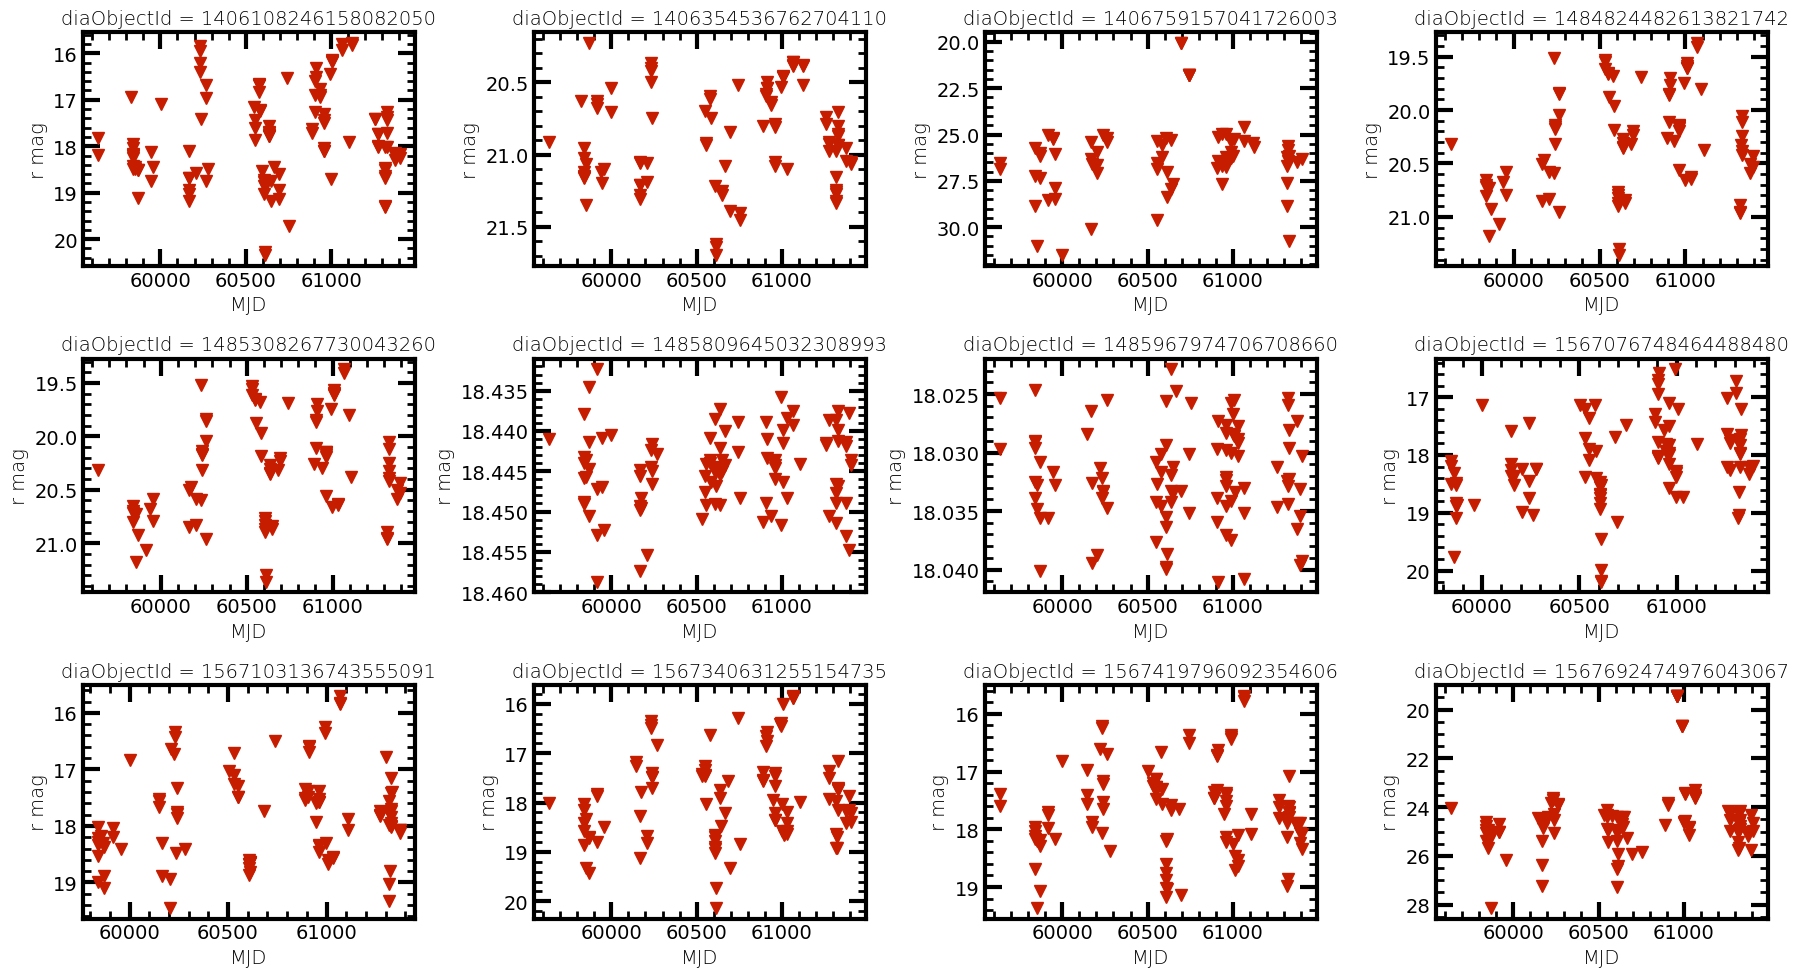

In [62]:
fig, ax = plt.subplots(3, 4, figsize=(18, 10), sharey=False, sharex=False)

objids = np.unique(forced_source_dia_table['diaObjectId'])

obj = 0

for i in range(3):
    for j in range(4):

        findobj = (forced_source_dia_table['diaObjectId'] == objids[obj])

        ax[i, j].plot(forced_source_dia_table['expMidptMJD'][findobj], forced_source_dia_table['fsodo_gmag'][findobj],
                      plot_filter_symbols['r'], color=plot_filter_colors['r'], ms=8)
        ax[i, j].set_xlabel('MJD')
        ax[i, j].set_ylabel('r mag')
        ax[i, j].set_title("diaObjectId = {0}".format(objids[obj]), fontsize=14)
        ax[i, j].invert_yaxis()
        
        obj = obj+1

plt.tight_layout()

## 4. Identify objects by color from the Object table photometry

Both AGN and stars are point-like sources, but their colors differ. AGN can be selected by their position in color-color diagrams. 

#### 4.1 Create color-color diagrams for point-like sources

#### 4.1.1 Query the object table

Query the Object table for point-like sources within 10 degrees of the central coordinates. Select only point sources using the extendedness parameter. Extended objects (e.g. galaxies) have extendedness equal to 1, while point sources have extendedness equal to 0. 

In [40]:
query = "SELECT TOP 10000 " \
        "objectId, coord_dec, coord_ra, refExtendedness, " \
        "scisql_nanojanskyToAbMag(u_psfFlux) as umag, " \
        "scisql_nanojanskyToAbMag(g_psfFlux) as gmag, " \
        "scisql_nanojanskyToAbMag(r_psfFlux) as rmag, " \
        "scisql_nanojanskyToAbMag(i_psfFlux) as imag, " \
        "scisql_nanojanskyToAbMag(z_psfFlux) as zmag, " \
        "scisql_nanojanskyToAbMag(y_psfFlux) as ymag " \
        "FROM dp02_dc2_catalogs.Object " \
        "WHERE CONTAINS(POINT('ICRS', coord_ra, coord_dec),CIRCLE('ICRS', 62, -37, 10))=1 " \
        "AND g_psfFlux > 360 "\
        "AND r_psfFlux > 360 "\
        "AND i_psfFlux > 360 "\
        "AND detect_isPrimary = 1 "\
        "AND refExtendedness =0"

Run the query and retrieve the results.

In [41]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [42]:
obj_table = job.fetch_result().to_table()

#### 4.1.2 Calculate colors for multiple bands. 

In [43]:
obj_table['color_u_g'] = obj_table['umag']-obj_table['gmag']
obj_table['color_g_r'] = obj_table['gmag']-obj_table['rmag']
obj_table['color_r_i'] = obj_table['rmag']-obj_table['imag']
obj_table['color_i_z'] = obj_table['imag']-obj_table['zmag']
obj_table['color_z_y'] = obj_table['zmag']-obj_table['ymag']

#### 4.1.3 Plot color-color diagrams

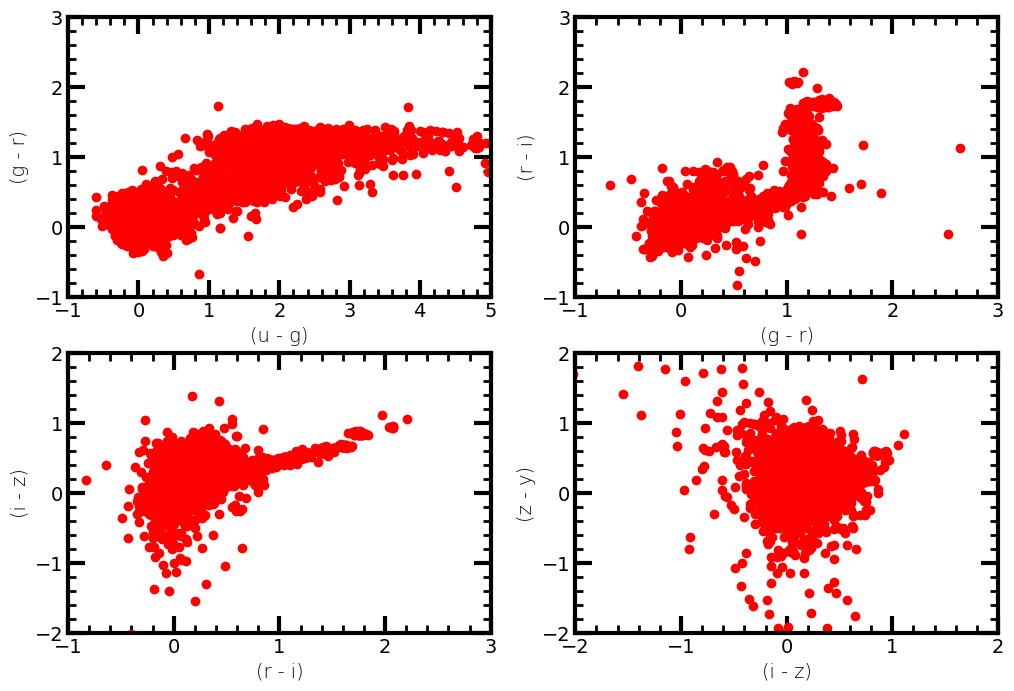

In [44]:
fig, ax  = plt.subplots(2, 2, figsize=(12, 8))

ax[0,0].plot(obj_table['color_u_g'], obj_table['color_g_r'], 'o', ms=6, color='red')
ax[0,0].set_xlabel('(u - g)')
ax[0,0].set_ylabel('(g - r)')
ax[0,0].set_xlim(-1, 5)
ax[0,0].set_ylim(-1, 3)

ax[0,1].plot(obj_table['color_g_r'], obj_table['color_r_i'] , 'o', ms=6, color='red')
ax[0,1].set_xlabel('(g - r)')
ax[0,1].set_ylabel('(r - i)')
ax[0,1].set_xlim(-1, 3)
ax[0,1].set_ylim(-1, 3)

ax[1,0].plot(obj_table['color_r_i'], obj_table['color_i_z'] , 'o', ms=6, color='red')
ax[1,0].set_xlabel('(r - i)')
ax[1,0].set_ylabel('(i - z)')
ax[1,0].set_xlim(-1, 3)
ax[1,0].set_ylim(-2, 2)

ax[1,1].plot(obj_table['color_i_z'], obj_table['color_z_y'] , 'o', ms=6, color='red')
ax[1,1].set_xlabel('(i - z)')
ax[1,1].set_ylabel('(z - y)')
ax[1,1].set_xlim(-2, 2)
ax[1,1].set_ylim(-2,2)

plt.show()

#### 4.1.4 Select an object for further exploration

Since it is not possible to identify an AGN in this dataset, and to ensure there is at least an object that meets the selection criteria, we can select a data point at the outskirts of the group of stars. Many AGN lie in the bottom left region of the (r-i) vs (g-r) diagram. We can select the bottom leftmost point for further exploration.

In [45]:
bottom_left = np.argmin(obj_table['color_r_i'] + obj_table['color_g_r'])
obj_id = obj_table[bottom_left]['objectId']

Extract the objectId for this point and plot the color-color diagrams again. 

In [46]:
filter_objectid = (obj_table['objectId'] == obj_id)

(-2.0, 2.0)

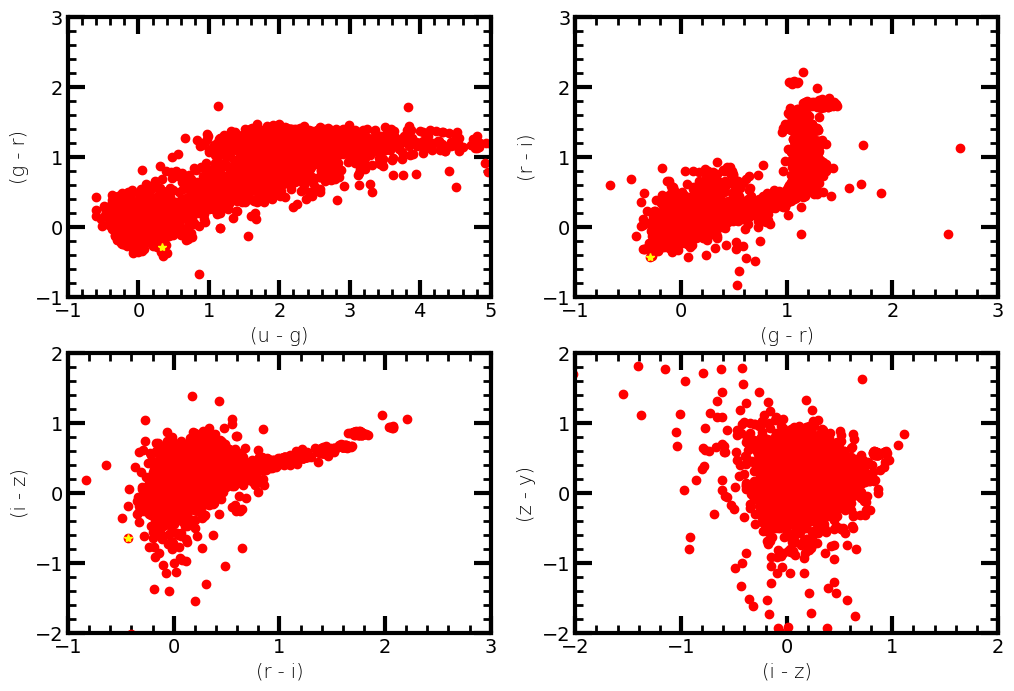

In [47]:
fig, ax  = plt.subplots(2, 2, figsize=(12, 8))

ax[0,0].plot(obj_table['color_u_g'], obj_table['color_g_r'], 'o', ms=6, color='red')
ax[0,0].plot(obj_table['color_u_g'][filter_objectid], obj_table['color_g_r'][filter_objectid], '*', ms=6, color='yellow')
ax[0,0].set_xlabel('(u - g)')
ax[0,0].set_ylabel('(g - r)')
ax[0,0].set_xlim(-1, 5)
ax[0,0].set_ylim(-1, 3)

ax[0,1].plot(obj_table['color_g_r'], obj_table['color_r_i'] , 'o', ms=6, color='red')
ax[0,1].plot(obj_table['color_g_r'][filter_objectid], obj_table['color_r_i'][filter_objectid] , '*', ms=6, color='yellow')
ax[0,1].set_xlabel('(g - r)')
ax[0,1].set_ylabel('(r - i)')
ax[0,1].set_xlim(-1, 3)
ax[0,1].set_ylim(-1, 3)

ax[1,0].plot(obj_table['color_r_i'], obj_table['color_i_z'] , 'o', ms=6, color='red')
ax[1,0].plot(obj_table['color_r_i'][filter_objectid], obj_table['color_i_z'][filter_objectid] , '*', ms=6, color='yellow')
ax[1,0].set_xlabel('(r - i)')
ax[1,0].set_ylabel('(i - z)')
ax[1,0].set_xlim(-1, 3)
ax[1,0].set_ylim(-2, 2)

ax[1,1].plot(obj_table['color_i_z'], obj_table['color_z_y'] , 'o', ms=6, color='red')
ax[1,1].plot(obj_table['color_i_z'][filter_objectid], obj_table['color_z_y'][filter_objectid], '*', ms=6, color='yellow')
ax[1,1].set_xlabel('(i - z)')
ax[1,1].set_ylabel('(z - y)')
ax[1,1].set_xlim(-2, 2)
ax[1,1].set_ylim(-2,2)

#### 4.2 Inspect the lightcurve for the selected object

Query the `ForcedSource` and `CcdVisit` tables to retrieve the lightcurve, including errors. 

In [48]:
query = "SELECT fs.band, fs.psfFlux, fs.psfFluxErr, " \
        "ccdv.expMidptMJD, " \
        "scisql_nanojanskyToAbMag(psfFlux) as psfMag, "\
        "scisql_nanojanskyToAbMagSigma(psfFlux, psfFluxErr) as psfMagErr "\
        "FROM dp02_dc2_catalogs.ForcedSource AS fs " \
        "JOIN dp02_dc2_catalogs.CcdVisit AS ccdv " \
        "ON fs.ccdVisitId = ccdv.ccdVisitId " \
        "WHERE objectId = " + str(obj_id)

Run the query and retrieve the results.

In [49]:
job = service.submit_job(query)
job.run()
job.wait(phases=['COMPLETED', 'ERROR'])
print('Job phase is', job.phase)

Job phase is COMPLETED


In [50]:
lightcurve = job.fetch_result().to_table()

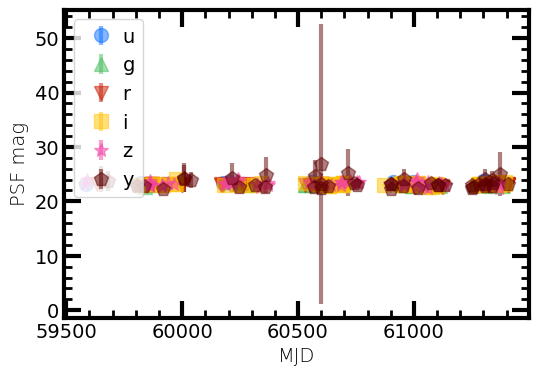

In [51]:
fig = plt.subplots(figsize=(6, 4))

for band in plot_filter_labels:
    
    filter_band = np.where(lightcurve['band'] == band)[0]

    plt.errorbar(lightcurve['expMidptMJD'][filter_band], lightcurve['psfMag'][filter_band], lightcurve['psfMagErr'][filter_band],
             fmt=plot_filter_symbols[band], markersize=10, color=plot_filter_colors[band], alpha = 0.5, label=band)
        
plt.xlabel('MJD')
plt.ylabel('PSF mag')
plt.legend(loc='upper left', handletextpad=0.1)
plt.show()